In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

<font color=red size=3>
    - Due to the issue of 20yr Treasure data(too short), all implementations below are without this dataset <br>
    - The original data is in "Interest rate.xlsx"
</font>

In [2]:
path_base = "libor_only.xlsx"
path_sofr = "sofr_only.xlsx"

def rename(path):
    """
    @Arg:
    path: path to file
    
    @Return:
    The raw data is terrible, return a better one where column names are sheet names of each
    """
    df_dict = pd.read_excel(path, sheet_name = None, index_col=0)
    df = pd.concat(df_dict.values(), axis=1)
    df.columns = list(df_dict.keys())
    
    return df
    

def merge_sofr(drop, path_base, path_sofr, libor = ["3mo_libor", "1mo_libor"]):
    """
    @Arg:
    drop: if we drop all NA
    path_base: path to the table of all basic data as well as libor
    path_sofr: path to table of sofr data
    libor: colname of libor, it will be used when we are updating them according with sofr
    
    @Return:
    Return a concatenated table of based on libor and sofr.
    Older data are with libor, and the newer one are replaced by sofr
    """
    
    df_base = rename(path_base)
    #display(df_base.loc["1985"])
    df_sofr = rename(path_sofr)
    #display(df_base)
    #display(df_sofr)
    
    df_sofr.columns = libor
    df_base.update(df_sofr)
    #display(df_base.loc["1985"])
    
    if drop:
        df_base = df_base.dropna(axis=0, how="any")
        #display(df_base)
        df_index = df_base.index
        df_base = df_base.reset_index(drop=True)
    
    return df_base, df_index

In [3]:
df, df_index = merge_sofr(True, path_base, path_sofr)

,30yr,10yr,5yr,2yr,1yr,6mo,3mo_libor,1mo_libor,1d
0,11.5730,11.5380,11.1770,10.3990,9.5820,9.1100,9.38000,9.19000,8.93
1,11.6720,11.6560,11.2910,10.4520,9.6040,9.1070,9.38000,9.19000,8.62
2,11.6110,11.6020,11.2330,10.3980,9.5520,9.0330,9.44000,9.25000,8.75
3,11.5720,11.5590,11.1850,10.3610,9.5030,8.9780,9.31000,9.13000,8.75
4,11.5120,11.4840,11.1190,10.2710,9.3630,8.8120,9.19000,9.00000,8.58
...,...,...,...,...,...,...,...,...,...
7679,4.1414,4.0123,4.1844,4.4142,4.5294,4.4756,4.43957,3.76771,3.08
7680,4.1639,4.0478,4.2283,4.4824,4.6019,4.5359,4.46029,3.80486,3.08
7681,4.0919,4.0419,4.2670,4.5447,4.6258,4.5838,4.45971,3.84157,3.08
7682,4.1405,4.1005,4.3093,4.6197,4.6945,4.5520,4.50843,3.83571,3.08


<AxesSubplot: >

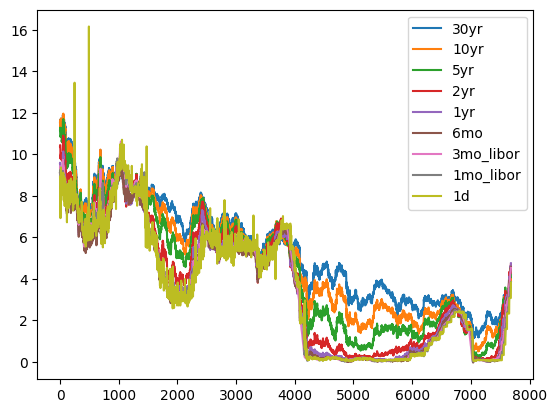

In [4]:
display(df)
df.plot()

<AxesSubplot: >

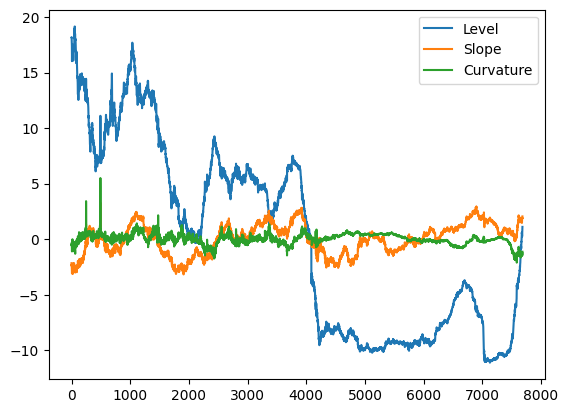

In [5]:
pca = PCA(n_components=3)
components = pca.fit_transform(df)
df_components = pd.DataFrame(data=components, columns=['Level', 'Slope', 'Curvature'])
df_components.plot() #???

<font color=red size=3>
    - According to the plot above(if it is indeed correct), should we use some model other than CIR? <br>
    - The real level produces is generally downward (is it?), while CIR always drift a process back to the mean.
</font>

# CIR

In [6]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [7]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_CIR_process(
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[t - 1])
            + CIR_params.c * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        #print(dsigma_t)
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t):
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

CIRParams(a=0.001558926304042135, b=9.679545323496383, c=0.05003944374969431)


<AxesSubplot: >

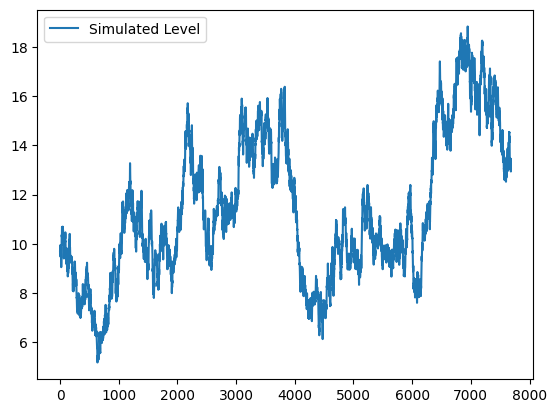

In [9]:
proc_level = df_components.Level.to_numpy()
proc_level += abs(min(proc_level)) + 0.001

est_param_level = estimate_CIR_params(proc_level)
print(est_param_level)

sim_level = get_CIR_process(len(df_components), est_param_level)
temp = pd.DataFrame({"Simulated Level": sim_level})
temp.plot()

# OU

In [10]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class OUParams:
    """OU process params."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float

In [11]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_OU_process(
    T: int,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    #print(dW)
    return _generate_OU_process(dW, OU_params, sigma_0)


def _generate_OU_process(
    dW: np.ndarray,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the OU process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, OU_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            OU_params.a * (OU_params.b - sigma_t[t - 1]) + OU_params.c * dW[t]
        )
        # if Nan in simulation raise an error.
        #_validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], OU_params: OUParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return OU_params.b


#def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
#    if np.isnan(dsigma_t):
#        raise ValueError(
#            "OU process simulation crashed, check your OU_params. "
#            + "Maybe choose a smaller c value."
#        )
#    return None

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_OU_params(sigma_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma = sigma_t[:-1]
    y = np.diff(sigma_t)
    x2 = sigma
    x1 = np.array([1.0]*len(x2))
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return OUParams(a, b, c)

<AxesSubplot: >

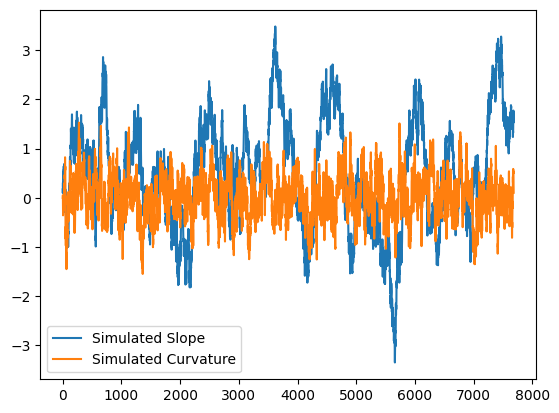

In [109]:
proc_slope = df_components.Slope.to_numpy()
proc_curvature = df_components.Curvature.to_numpy()

est_param_slope = estimate_OU_params(proc_slope)
est_param_curvature = estimate_OU_params(proc_curvature)
#print(est_param_slope)
#print(est_param_curvature)

sim_slope = get_OU_process(len(df_components), est_param_slope)
sim_curvature = get_OU_process(len(df_components), est_param_curvature)

#x1 = np.linspace(0,len(df_components)-1,len(df_components))
#x2 = np.linspace(0,len(df_components)-1,len(df_components))
#plt.plot(x1, sim_slope)
#plt.plot(x2, sim_curvature)
#plt.show()

temp = pd.DataFrame({"Simulated Slope": sim_slope, "Simulated Curvature": sim_curvature})
temp.plot()

#plt.plot(sim_curvature)

# Reconvert

In [28]:
data_recon = (components @ pca.components_)
data_recon = data_recon + np.tile(df.mean().to_numpy(), (len(df), 1))
df_recon = pd.DataFrame(data_recon)
df_recon.columns = df.columns

<AxesSubplot: >

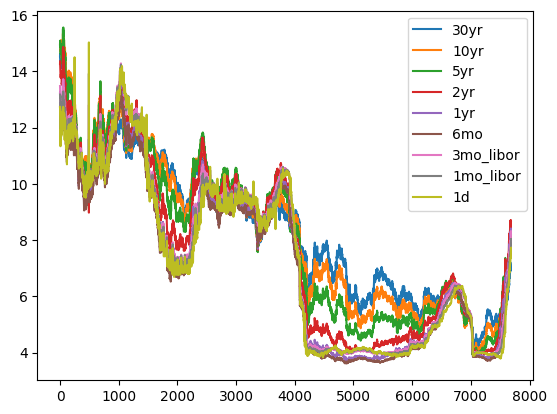

In [29]:
df_recon.plot()

In [30]:
ma = df_recon.set_index(df_index).resample("M").mean()

# ACM

In [92]:
def vec(x):
    return np.reshape(x, (-1, 1))
def vec_quad_form(x):
    return vec(np.outer(x, x))

#rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120) 
rx_maturities = (360, 120, 60, 24, 12, 6, 3, 1) 
n_maturities = 9
K = 3

ttm = np.arange(1.0, n_maturities + 1.0)[np.newaxis, :] / 12.0
logPrices = -df_recon.to_numpy()*ttm
rf = -logPrices[:-1, [0]]
rx = logPrices[1:, :-1] - logPrices[:-1, 1:] - rf

In [93]:
np.shape(df_recon.to_numpy())

(7684, 9)

In [94]:
np.shape(rx)

(7683, 8)

In [95]:
X = components.T
t = len(df_recon)-1

X_lhs = X[:, 1:]  #X_t+1. Left hand side of VAR.
X_rhs = np.vstack((np.ones((1, t)), X[:, 0:-1])) #X_t and a constant.
var_coeffs = (X_lhs @ np.linalg.pinv(X_rhs))
mu = var_coeffs[:, [0]]
phi = var_coeffs[:, 1:]

v = X_lhs - var_coeffs @ X_rhs
Sigma = v @ v.T / t

In [96]:
#selected_rx = rx[:, [x - 2 for x in rx_maturities]].T  # Offset by 2 since index 0 is excess return on a 2m bond
selected_rx = rx[:, :-1].T
N = selected_rx.shape[0]
Z = np.vstack((np.ones((1, t)), v, X[:, 0:-1]))  #Innovations and lagged X
abc = selected_rx @ np.linalg.pinv(Z)
E = selected_rx - abc @ Z
sigmasq_ret = np.sum(E * E) / E.size

a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]

In [97]:
# Step (3) of the three-step procedure: Run cross-sectional regressions
BStar = np.squeeze(np.apply_along_axis(vec_quad_form, 1, beta.T))
lambda1 = np.linalg.pinv(beta.T) @ c
lambda0 = np.linalg.pinv(beta.T) @ (a + 1/2 * (BStar @ vec(Sigma) + sigmasq_ret))

In [98]:
# Run bond pricing recursions
A = np.zeros((1, n_maturities))
B = np.zeros((K, n_maturities))

delta = rf.T @ np.linalg.pinv(np.vstack((np.ones((1, t)), X[:, 0:-1])))
delta0 = delta[[0], [0]]
delta1 = delta[[0], 1:]

A[0, 0] = - delta0
B[:, 0] = - delta1

for i in range(0, n_maturities - 1):
    A[0, i+1] = A[0, i] + B[:, i].T @ (mu - lambda0) + 1/2 * (B[:, i].T @ Sigma @ B[:, i] + 0 * sigmasq_ret) - delta0
    B[:, i+1] = B[:, i] @ (phi - lambda1) - delta1



<Figure size 921.6x691.2 with 0 Axes>

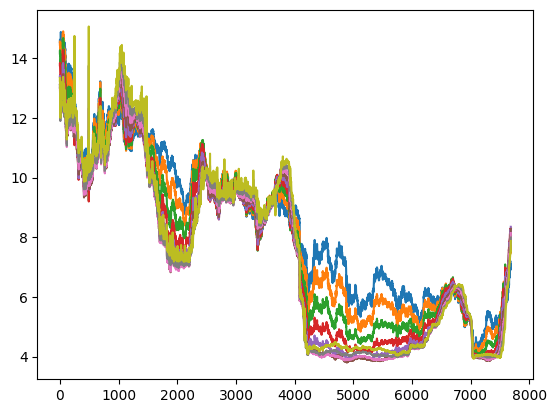

In [107]:
# Construct fitted yields
fittedLogPrices = (A.T + B.T @ X).T
fittedYields = - fittedLogPrices / ttm

plt.interactive(True)
plt.figure(dpi=144)
fig, axes = plt.subplots()

axes.plot(fittedYields, label = "Reconverted Yields")
plt.show()

<AxesSubplot: >

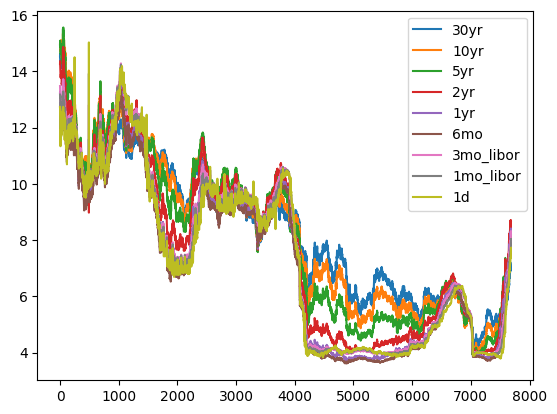

In [108]:
df_recon.plot()